In [6]:
from sklearn.preprocessing import FunctionTransformer

from reskit.norms import binar_norm
from reskit.core import Transformer, Pipeliner

from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import os
import pandas as pd
import numpy as np

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def orig(x):
    return x

from matplotlib import pyplot as plt
%matplotlib inline
import re

from tqdm import tqdm_notebook as tqdm

In [2]:
def get_autism(path_to_read='../Data/dti/', distances=True):
    def get_autism_distances(loc_name):
        with open(loc_name, 'r') as f:
            read_data = f.readlines()

        read_data = pd.DataFrame(
            np.array([np.array(item[:-1].split()).astype(int) for item in read_data]))

        return read_data

    def get_distance_matrix(coords):
        if type(coords) == pd.core.frame.DataFrame:
            coords = coords.values
        elif type(coords) != np.ndarray:
            print('Provide either pandas df or numpy array!')
            return -1

        shape = len(coords)
        dist_matrix = np.zeros((shape, shape))
        del shape
        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                dist_matrix[i, j] = np.linalg.norm(coords[i, :] - coords[j, :])
                dist_matrix[j, i] = dist_matrix[i, j]
        return dist_matrix

    target_vector = []  # this will be a target vector (diagnosis)
    matrices = []  # this will be a list of connectomes
    all_files = sorted(os.listdir(path_to_read))
    matrix_files = [
        item for item in all_files if 'DTI_connectivity' in item and 'All' not in item]
    distance_files = [
        item for item in all_files if 'DTI_region_xyz_centers' in item and 'All' not in item]

    # for each file in a sorted (!) list of files:
    for filename in matrix_files:

        A_dataframe = pd.read_csv(
            path_to_read + filename, sep='   ', header=None, engine='python')
        A = A_dataframe.values  # we will use a list of numpy arrays, NOT pandas dataframes
        matrices.append(A)# append a matrix to our list
        if "ASD" in filename:
            target_vector.append(1)
        elif "TD" in filename:
            target_vector.append(0)
    asd_dict = {}
    asd_dict['X'] = np.array(matrices)
    asd_dict['y'] = np.array(target_vector)
    if distances:
        dist_matrix_list = []
        for item in distance_files:
            # print(item)
            cur_coord = get_autism_distances(path_to_read + item)
            cur_dist_mtx = get_distance_matrix(cur_coord)
            dist_matrix_list += [cur_dist_mtx]

        asd_dict['dist'] = np.array(dist_matrix_list)

    return asd_dict

In [3]:
def matrix_eig(data):
    #new_data = {}
    #new_data['y'] = data['y']
    data['X_vec'] = np.zeros(shape = (data['X'].shape[0], data['X'].shape[1] * data['X'].shape[1]))
    for i in np.arange(data['X'].shape[0]):
        curs, vecs = np.linalg.eig(data['X'][i])
        indx = abs(curs).argsort()
        vecs = vecs[indx]
        curs = curs[indx]
        data['X_vec'][i] = convert(vecs.dot(np.diag(curs)).T, 'mat2vec', 264)
    return data

#Функция преобразования матрицы в вектор и наоборот
def convert(A, mode, size = 264):
    if mode == 'mat2vec':
        A_vec = np.reshape(A, A.shape[0]*A.shape[1])
        return A_vec
        
    if mode == 'vec2mat':
        A_mat = np.reshape(A, (size, A.shape[0] / size ))
        return A_mat

In [4]:
params = {
    'text.usetex'         : True,
    'text.latex.unicode'  : True,
    'text.latex.preamble' : r"\usepackage[T2A]{fontenc}",
    'font.size'           : 15,
    'font.family'         : 'lmodern'
    }

plt.rcParams.update(params)



def print_boxplot(data1, data2, figsize = (10.5,6.5), save = False):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize)
    
    bp  = ax2.boxplot(data2, 0, '+')
    
    x = np.arange(len(data1))
    ax1.plot(x, data1)
    
    plt.setp(bp['boxes'],    color='DarkGreen')
    plt.setp(bp['whiskers'], color='DarkOrange', linestyle = '-')
    plt.setp(bp['medians'],  color='DarkBlue')
    plt.setp(bp['caps'],     color='Gray')
    
    ax1.set_title(r'Process of learning')
    ax2.set_title(r'BoxPlot')
    ax1.set_ylabel(r'ROC AUC mean')
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
    ax2.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
    
    plt.show()
    if save: fig.savefig('fig.png', dpi = 300)

### Обучим одну модель на X_tr

In [5]:
data = '../Data/dti/'
data = Transformer(get_autism).fit_transform(data)
data = Transformer(binar_norm).fit_transform(data)
data = Transformer(matrix_eig).fit_transform(data)

In [7]:
M = data['X']
X = data['X_vec']
y = data['y']

In [8]:
def split_features(X, k_tr = 3, k_bag = 3):
    X_tr = X[:,-264 * k_tr:]
    print X_tr.shape, 264 * k_tr
    X_bag = []
    for i in range( (264 - k_tr) / k_bag ):
        X_i = X[:, (0+i)*264 :(k_bag+i)*264]
        X_bag.append(X_i)
    X_bag = np.array(X_bag)
    print X_bag[0].shape, 264*k_bag
    
    return X_tr, X_bag

In [9]:
import random

def supposed_index(X_bag):
    # X_bag: (size, 94, 1320)
    size = X_bag.shape[0] - 1
    
    ind = int(size - size * random.expovariate(1) / 5)
    if ind > size : ind = size
    if ind < 0  : ind = 0
    return ind

In [10]:
def join_features(X_tr, X_i):
    return np.concatenate((X_tr, X_i), axis = 1)

In [11]:
grid_cv = StratifiedKFold(n_splits=10,
                          shuffle=True,
                          random_state=0)

eval_cv = StratifiedKFold(n_splits=10,
                          shuffle=True,
                          random_state=1)

In [12]:
def get_grid_and_score(X, y, collect_n = 0):
    steps = [('selector', VarianceThreshold()), ('scaler', MinMaxScaler()), ('classifier', LogisticRegression())] 
    pipeline = Pipeline(steps)

    param_grid = dict(classifier__penalty=['l1'], 
                      classifier__C      =[0.1, 0.5, 1.0]
                     )
    scoring = 'roc_auc'
    grid_clf = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, n_jobs=-1, cv=grid_cv)

    grid_clf.fit(X, y)
    
    steps[-1] = steps[-1][0], grid_clf.best_estimator_
    pipeline = Pipeline(steps)
    if not collect_n:
        scores = cross_val_score(pipeline, X, y, scoring=scoring, cv=eval_cv, n_jobs=-1)
        return np.mean(scores)
    if collect_n:
        scores = []
        rd = eval_cv.random_state
        for i in tqdm(range(1, collect_n)):
            sc = cross_val_score(pipeline, X, y, scoring=scoring, cv=eval_cv, n_jobs=-1)
            scores.append(np.mean(sc))
            eval_cv.random_state += i
        eval_cv.random_state = rd
        print grid_clf.best_estimator_
        return scores

In [13]:
table_score = []

X_tr, X_bag = split_features(X)
ar_to_improve = np.zeros(X_bag.shape[0])
table_score.append(get_grid_and_score(X_tr, y))

print "SCORE: ", table_score[0]
print ""

for i in tqdm(range(500)):
    ind = supposed_index(X_bag)
    score = get_grid_and_score(join_features(X_tr, X_bag[ind]), y)
    if score > table_score[-1]:
        ar_to_improve[ind] += 0.5 * score
        #print "          SCORE: ", score
        #print "          IND:   ", ind
    for j, ar in enumerate(ar_to_improve):
        if ar >= 1:
            X_tr = join_features(X_tr, X_bag[j])
            X_bag = np.delete(X_bag, j, axis=0)
            ar_to_improve = np.delete(ar_to_improve, j, axis=0)
            table_score.append(score)
            print "epoch #", i
            print "SCORE: ", score
            print "ADD:   ", j
            print ""

print ar_to_improve

(94, 792) 792
(94, 792) 792
SCORE:  0.684666666667

epoch # 20
SCORE:  0.782666666667
ADD:    83

epoch # 40
SCORE:  0.795
ADD:    79

epoch # 44
SCORE:  0.818
ADD:    68

epoch # 83
SCORE:  0.832
ADD:    65

epoch # 104
SCORE:  0.845666666667
ADD:    62

epoch # 145
SCORE:  0.846
ADD:    80

epoch # 219
SCORE:  0.856
ADD:    79

epoch # 384
SCORE:  0.860333333333
ADD:    54


[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.87983333
  0.4205      0.44766667  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.72683333  0.          0.
  0.41066667  0.          0.          0.          0.          0.          0.431
  0. 

In [14]:
scores = get_grid_and_score(X_tr, y, 100)


Pipeline(steps=[('selector', VarianceThreshold(threshold=0.0)), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


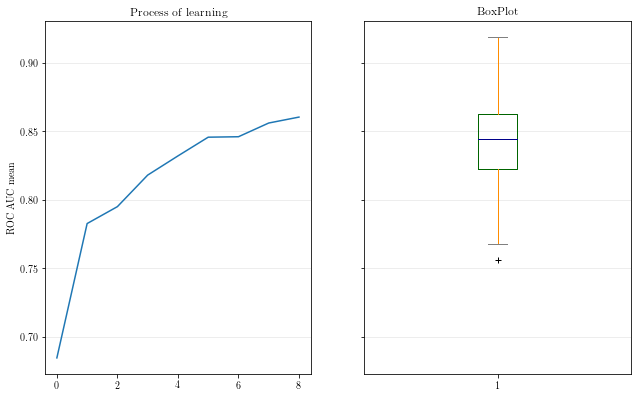

In [15]:
print_boxplot(table_score, scores, save = True)